In [1]:
#Import the required python modules 
import numpy as np
from pylab import *
import scipy.integrate as spi
import scipy.stats
from scipy.optimize import fmin
import seaborn as sb
import pandas as pd
%matplotlib inline


Step 1:

    *Create a function called 'eqs_model' that stores and runs the SEIR/SEI Zika model differential equations. 

   The full model is as follows: 

        dSh/dt = -βh*Sh*Im 

        dEh/dt = βh*Sh*Im - αh*Eh 

        dIh/dt = αh*Eh – γ*Ih  

        dRh/dt = γ*Ih 

        dSm/dt = δ - βm*Sm*Ih - δ*Sm 

        dEm/dt = βm*Sm*Ih – (δ + αm)*Em  

        dIm/dt = αm*Em - δ*Ιm 

Step 2:

    * Create a parameters bin for beta, alpha, gamma, and delta, that can be easily used to optimize later with fmin. 

In [2]:
#Solving the differential equations.

def eqs_model(modelParams, t, *zikaParams):
    
    '''Defining SEIR/SEI System of Equations for Humans and Mosquitos'''
    
    beta_H, beta_M, alpha_H, alpha_M, gamma = zikaParams[1]
    
    # delta is fixed because mosquitoes live an average of 7 days
    delta = 0.07 
    
    #Creating an array of equations
    Y = np.zeros((7))
    #S0 = -beta_H * Sh * Im
    Y[0] = -beta_H*modelParams[0]*modelParams[6]
    #E0 = beta_H* Sh * Im) - alpha_H * Se
    Y[1] = beta_H*modelParams[0]*modelParams[6] - alpha_H*modelParams[1]
    #I0 = alpha_H * Se - gamma * Si
    Y[2] = alpha_H*modelParams[1] - gamma*modelParams[2]
    #R0 = gamma * Si 
    Y[3] = gamma*modelParams[2]
    
    #S1 = delta - beta_M *(Sm)(Ih) - (delta)(beta_M)
    Y[4] = delta - beta_M*modelParams[4]*modelParams[2] - delta*beta_M
    #E1 = beta_M * Sm*Ih - (delta + alpha_M) * Ei
    Y[5] = beta_M*modelParams[4]*modelParams[2] - (delta + alpha_M)*modelParams[5]
    #I = (delta + alpha_M) * Ei
    Y[6] = alpha_M*modelParams[5] - delta*modelParams[6]
    
    return Y


Step 3:

    * Create a function to store the results of the eqs_model function in a dataframe 
    * 'S/E/I/R', 'Sm/Em/Im', and 'Day' columns. 

In [3]:
#Save results of the simulation to a DF

def results(SEIR, startday):
    """ """
 
    resdf = pd.DataFrame(SEIR, columns=['S', 'E', 'I', 'R', 'Sm', 'Em', 'Im'])
    #ix = pd.DatetimeIndex(pd.date_range(startday, periods=len(resdf), freq='D'))
    #resdf.index = ix
    resdf['Day'] = resdf.index
    resdf.set_index(['Day'], inplace=True)
    
    return resdf


Step 4:

        * Create a function that runs the eqs_model with given parameters
        * Allow for the ability to run for a specific number of days. 
        * np.linspace allows the simulation to run in time steps (days).
        * Within this function rteurn the results of the simulation into the results function to save as a dataframe.
        * spi.odeint correctly runs the differential equations and updates the values simultaneously 

In [4]:
#Function to run the model and build for the score function and model fitting with fmin

def run_model(modelParams, zikaParams, numdays, startday):
    
    ''''''
   
    t = np.linspace(0, numdays, numdays)
    funcInput = (modelParams, zikaParams)
    SEIR = spi.odeint(eqs_model, modelParams, t, args=funcInput)
   
    df = results(SEIR, startday)
    
    return df



Step 5:

    * Create a function that stores all DF manipulation/s to make an easily accesible master DF 
    * Used to be plotted against the fitted model or other data. 

  Model DF:

    * Start by generating the results of the SEIR/SEI model into a DF
    * Create and 'Offset Day' column, offday is a changable variable
    * Rename and set that 'Offset Day' to 'Day' as the index to match the Miami DF for merging
    
  Miami DF:
     
     * Import the Miami DF
     * Create a 'Day' column and subtracty from the index so that it starts on day 1
     * Make 'Day' column the index
     
  Master DF:
 
     * Merge (concatinate) the MiamiDF and ModelDF on the 'Day" indexes
     * Interpolate the the 'Total' columns so that there are no NaNs
     * Reduce the DF frame to 25 days (peak for teh Miami data)
    

In [5]:
def master_DF(zikaParams, modelParams, numdays, startday, offday):
    
    result  = run_model(seir, zika, 78, 1)

    result['Offset Day'] = pd.Series(result.index - offday)

    result = result[result['Offset Day'] >= 1]

    result.set_index(['Offset Day'], inplace=True)

    result.index.names = ['Day']


    miamiData = pd.read_csv('/home/jbrindle/Downloads/Copy of Florida_Daily_Cases - Sheet1.csv')

    miamiData['Day'] = pd.Series(miamiData['Time'] - 211 + 1)

    miamiData.set_index(['Day'], inplace=True)



    frames = [miamiData, result]

    masterDF = pd.concat(frames, axis=1)

    masterDF['Wynwood Total'].interpolate(inplace=True)

    masterDF = masterDF[masterDF.index <= 15]
    
    return masterDF

Step 6:

    * Simple score function that runs the df_function to generate a DF
    * Compare the Wynwood Total data to the R model data
    * Subtract and square to generate score

In [6]:
#Simple score function for input into scipy fmin model fit function

def score(zikaParams, modelParams, numdays, startday, offday):
    """ """
    
    result  = run_model(modelParams, zikaParams, numdays, startday)
    
    result['Offset Day'] = pd.Series(result.index - offday)

    result = result[result['Offset Day'] >= 1]
    
    result.set_index(['Offset Day'], inplace=True)
    
    result.index.names = ['Day']
    

    miamiData = pd.read_csv('/home/jbrindle/Downloads/Copy of Florida_Daily_Cases - Sheet1.csv')
    
    miamiData['Day'] = pd.Series(miamiData['Time'] - 211 + 1)
    
    miamiData.set_index(['Day'], inplace=True)
    
    

    frames = [miamiData, result]
    
    mergedDf = pd.concat(frames, axis=1)
    
    mergedDf['Wynwood Total'].interpolate(inplace=True)
    
    mergedDf = mergedDf[mergedDf.index <= 15]

    data  = mergedDf['Wynwood Total']

    model = mergedDf['R']
    
    
    score = ((data-model)**2).sum()


    return score

Step 7: 

    * Create a function that uses fmin to 'fit' the model based on the score function
    * Re-run the model withthe optimal Zika Parameters
    * Redo the 'Offset' because the model data needs to account for real life scenarios
        --There should be a delay between time of I and the detection of Zika (assumed 2 weeks)

In [72]:
#Function to fir the simulation data to the Miami data

def fits(zikaParams, modelParams, numdays, startday, offday):
    
    funcInput = (modelParams, numdays, startday, offday)
    
    fits.opt = fmin(score, zikaParams, funcInput)
    
    fitModel = run_model(modelParams, fits.opt, numdays, startday)
    
    fitModel['Offset Day'] = pd.Series(fitModel.index - offday)

    fitModel = fitModel[fitModel['Offset Day'] >= 1]

    fitModel.set_index(['Offset Day'], inplace=True)

    fitModel.index.names = ['Day']
    
    fitModel = fitModel[fitModel.index <= 15]

    return fitModel

In [73]:
seir = [7277, 0.0, 1.0, 0.0, 15000, 0.0, 0.0]
zika = [0.06, 0.009, 0.02, 0.02, 0.02]


In [74]:
df = master_DF(zika, seir, 78, 1, 9)
fitModel = fits(zika, seir, 78, 1, 9)

In [75]:
fitModel

,S,E,I,R,Sm,Em,Im
Day,,,,,,,
1,-5.713182e-18,7263.932630,8.424067,5.643304,0.006518,3857.433616,4085.395393
2,-5.602463e-15,7262.610372,8.826278,6.563350,0.006208,3314.045729,4085.099628
3,-3.562504e-16,7261.288355,9.187583,7.524062,0.005955,2847.207787,4045.470877
4,-2.380666e-16,7259.966579,9.512118,8.521303,0.005745,2446.135651,3974.745655
5,7.617281e-15,7258.645043,9.803602,9.551354,0.005568,2101.564643,3879.815418
6,-9.954933e-14,7257.323748,10.065378,10.610874,0.005419,1805.535130,3766.429026
7,-7.206437e-14,7256.002694,10.300450,11.696856,0.005292,1551.208835,3639.365316
8,2.196609e-14,7254.681880,10.511520,12.806600,0.005183,1332.710793,3502.580788
9,2.519062e-13,7253.361306,10.701014,13.937680,0.005089,1144.993697,3359.335609


In [76]:
y = fits.opt
y

array([  3.05370271e+00,   5.63122067e-01,   1.79713169e-04,
         7.98944448e-02,   1.05258418e-01])

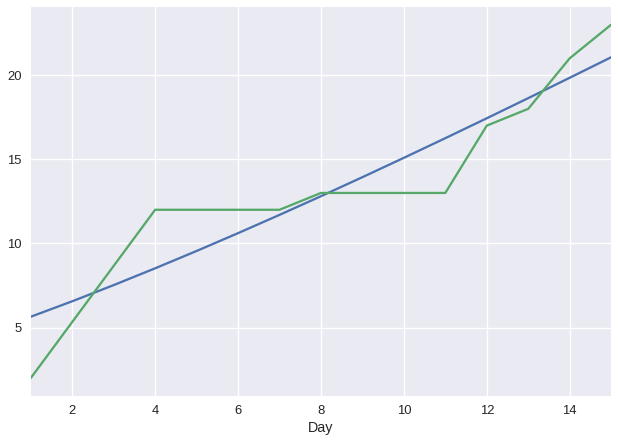

In [77]:
sb.set_context("talk")
fitModel['R'].plot()
df['Wynwood Total'].plot()

Optimization terminated successfully.
         Current function value: 77.480773
         Iterations: 228
         Function evaluations: 392


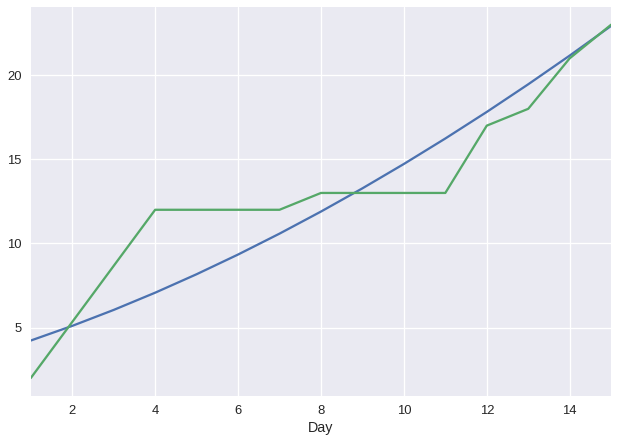

In [79]:
df2 = master_DF(zika, seir, 78, 1, 11)
fitModel2 = fits(zika, seir, 78, 1, 11)

sb.set_context("talk")
fitModel2['R'].plot()
df2['Wynwood Total'].plot()

In [ ]:
seirFit = [7277, 0.0, 1.0, 0.0, 15000, 0.0, 0.0]
zikaFit = [0.1777326 ,  0.02426253,  0.01185499,  0.00944282,  0.00123915]
#           BetaH          BetaM        AlphaH      AlphaM       Gamma

In [ ]:
# Create a loop of the scores function to determine the best offset


def loop_score(zikaParams, modelParams, numdays, startday):
    
        loopScore = {}
        for x in range(1, 25):
               loopScore[x] = score(zikaParams, modelParams, 78, 1, x)
       
        return loopScore

In [ ]:
x = loop_score(zikaFit, seirFit, 78, 1)

x

In [ ]:
plt.plot(*zip(*sorted(x.items())))
plt.show()